In [129]:
import requests
import os
import json
import pandas as pd
import numpy as np
import re
from collections import Counter 
import copy
from re import search
import random 
from bs4 import BeautifulSoup
from urllib.request import urlopen
import spacy
nlp = spacy.load('en_core_web_sm')
from tqdm.notebook import tqdm
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.lm import KneserNeyInterpolated
from nltk.util import ngrams as ng

In [9]:
source = urlopen('https://en.wikipedia.org/wiki/Non-fungible_token').read()
# Make a soup 
soup = BeautifulSoup(source,'lxml')

content_urls = [i for i in re.findall(r'<a href=([^\s > # ]+)', str(soup.find_all('p')) ) if i != '"']
content_urls = [i.strip('\"') for i in content_urls]
content_urls = ['https://en.wikipedia.org' + i for i in content_urls]
content_urls = ['https://en.wikipedia.org/wiki/Non-fungible_token'] + content_urls

f = open("wikipedia_articles.txt", "w")

for url in tqdm(content_urls):
    source = urlopen(url).read()
    # Make a soup 
    soup = BeautifulSoup(source,'lxml')

    # Extract the plain text content from paragraphs
    text = ''
    for paragraph in soup.find_all('p'):
        text += paragraph.text

    # dropping footnotes, removing newline chars
    text = re.sub(r'\[.*?\]+', '', text).replace('\n', '')
    f.write(text + '\n')

f.close()

    

  0%|          | 0/124 [00:00<?, ?it/s]

In [38]:
preprocessed = []
all_stopwords = nlp.Defaults.stop_words
    
f = open("wikipedia_articles.txt", "r")
lines = f.readlines()

for line in tqdm(lines): 
    preprocessed.extend(nlp(line))

f.close()

  0%|          | 0/124 [00:00<?, ?it/s]

In [39]:
non_stop_words_frequency = Counter([token.lemma_.lower() for token in preprocessed if (not token.is_stop) and (not token.is_punct)])
common_words = non_stop_words_frequency.most_common(20)
print(common_words)

[('film', 1159), ('game', 1044), ('work', 1034), ('include', 948), ('bitcoin', 821), ('use', 789), ('new', 760), ('release', 750), ('time', 660), ('blockchain', 646), ('copyright', 607), ('year', 595), ('$', 573), ('create', 567), ('company', 560), ('user', 512), ('right', 481), ('art', 480), ('million', 479), ('\xa0', 471)]


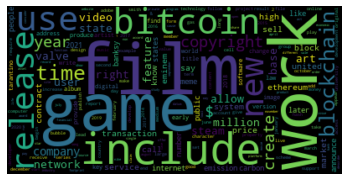

In [40]:
wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=non_stop_words_frequency)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [25]:
df = pd.read_csv("nfts.csv")
train, test = train_test_split(df, test_size = 1000)

In [31]:
test_tweets = test[['text']].values.flatten()

preprocessed_tweets = []

for tweet in tqdm(test_tweets):
    preprocessed_tweets.extend(nlp(tweet))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [43]:
non_stop_words_frequency_tweets = Counter([token.lemma_.lower() for token in preprocessed_tweets if (not token.is_stop) and (not token.is_punct)])

out_of_vocab_types = 0
for k,v in non_stop_words_frequency_tweets.items():
    if k not in non_stop_words_frequency:
        out_of_vocab_types += 1
    
normalized_out_of_vocab = out_of_vocab_types/len(non_stop_words_frequency_tweets)
print(f"Percentage of word types in test tweets not in wikipedia articles is {normalized_out_of_vocab}")
        

Percentage of word types in test tweets not in wikipedia articles is 0.6586187535092645


In [44]:
out_of_vocab_types = 0
for k,v in non_stop_words_frequency_tweets.items():
    if k not in non_stop_words_frequency:
        out_of_vocab_types += v
    
normalized_out_of_vocab = out_of_vocab_types/sum(non_stop_words_frequency_tweets.values())
print(f"Percentage of word tokens in test tweets not in wikipedia articles is {normalized_out_of_vocab}")
        

Percentage of word tokens in test tweets not in wikipedia articles is 0.5002646648380732


In [45]:
train_tweets = train[['text']].values.flatten()

preprocessed_tweets_train = []

for tweet in tqdm(train_tweets):
    preprocessed_tweets_train.extend(nlp(tweet))

  0%|          | 0/9100 [00:00<?, ?it/s]

In [46]:
non_stop_words_frequency_tweets_train = Counter([token.lemma_.lower() for token in preprocessed_tweets_train if (not token.is_stop) and (not token.is_punct)])

out_of_vocab_test = 0
for k,v in non_stop_words_frequency_tweets.items():
    if k not in non_stop_words_frequency_tweets_train:
        out_of_vocab_test += v
    
normalized_out_of_vocab = out_of_vocab_test/sum(non_stop_words_frequency_tweets.values())
print(f"Percentage of words in test tweets not in train tweets is {normalized_out_of_vocab}")
        

Percentage of words in test tweets not in train tweets is 0.03840046196044464


In [19]:
f = open("wikipedia_articles.txt", "r")
lines = f.readlines()
nlp.max_length = 1620195
docs = nlp(' '.join( [lines[i] for i in tqdm(range(80))]))

f.close()


first_nine_thousand = [sent for sent in docs.sents ][:9000]
pre_processed_lines = []
for x in first_nine_thousand:
    pre_processed_lines.append([token.lemma_.lower() for token in x if (not token.is_stop) and (not token.is_punct)])
        
train_data, padded_sents = padded_everygram_pipeline(3, pre_processed_lines)
model.fit(train_data, padded_sents)



In [128]:
test_tweets = test[['text']].values.flatten()

preprocessed_tweets_sentence_segmented = []

for tweet in tqdm(test_tweets):
    preprocessed_tweets_sentence_segmented.append(nlp(tweet))
        
        
pre_processed_lines_test = []
for x in preprocessed_tweets_sentence_segmented:
    pre_processed_lines_test.append([token.lemma_.lower() for token in x if (not token.is_stop) and (not token.is_punct)])
        

test_set = ng(pre_processed_lines_test, n = 3)

perplexities = []
for x in test_set: 
    perplexities.append(model.perplexity(x))
    
avg_perplexity = np.mean(perplexities)
print(f"Average average perplexity of this Wikipedia-trained language model on your processed Twitter test sentences is {avg_perplexity}")

Average average perplexity of this Wikipedia-trained language model on your processed Twitter test sentences is 88759.78751661068
